In [1]:
import numpy as np

#Define network

이전 주차의 TwoLayerNet에서 레이어 수, 가중치 초기화 및 감소, dropout, batchnorm 기능을 추가하였습니다.

**self.__init_weight()**과 **self.loss()**의 빈칸을 채워주세요!

In [ ]:
from collections import OrderedDict

class MultiLayerNet:
    '''
    input_size: 입력 크기 (MNIST의 경우 784)
    hidden_size_list: 은닉층 뉴런 개수의 리스트 (예: [100,100,100])
    output_size: 출력 크기 (MNIST의 경우 10)
    activation: 'relu' 또는 'sigmoid'
    weight_init_std: 가중치의 표준 편차 지정 (예: 0.01)
    'relu' 또는 'he'를 지정하면 He 초기화를 설정
    'sigmoid' 또는 'xavier'를 지정하면 Xavier 초기화를 설정
    weight_decay_lambda: Weight Decay(L2 정규화)의 강도
    use_dropout: Dropout을 사용할지 여부
    dropout_ration: Dropout 비율
    use_batchNorm: Batch Normalization을 사용할지 여부
    '''

    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0,
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        self.__init_weight(weight_init_std)

        # 레이어 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])

            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()


    def __init_weight(self, weight_init_std):
        """가중치 초기값 설정
        weight_init_std : 가중치의 표준 편차 지정 (예: 0.01)
        'relu' 또는 'he'를 지정하면 "He 초기화"를 설정
        'sigmoid' 또는 'xavier'를 지정하면 "Xavier 초기화"를 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size] # 각 층의 뉴런 갯수
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            # Xavier normal initialization : W ~ N(0, (2/(n_in+n_out))) 저번 강의 주차에서 나온 공식들
            # He normal initialization : W ~ N(0, 2/n_in)
            # 이 코드에서 현재 층 뉴런: 'all_size_list[idx]', 이전 층 뉴런: 'all_size_list[idx-1]'
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2 / all_size_list[idx])  # ReLU
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(2 / all_size_list[idx]+all_size_list[idx-1])  # sigmoid
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])


    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x


    def loss(self, x, t, train_flg=False):
        """손실 함수 정의
        입력 값 x는 입력 데이터, t는 정답 레이블
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum( W ** 2 )  # L2 norm: (람다/2N) * ||W||^2 
            # 분모의 'N'은 생략된다고 함 보통.
        return self.last_layer.forward(y, t) + weight_decay


    def accuracy(self, x, t):
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy


    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)


        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

## Xavier normal initialization : W ~ N(0, (2/(n_in+n_out)))
## He normal initialization : W ~ N(0, 2/n_in)

#Layers

각 레이어에는 init, forward, backward 함수가 정의되어 있습니다.

sigmoid 계층이 추가되었습니다.

In [7]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b

        self.x = None
        self.original_x_shape = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)
        return dx

In [8]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [9]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

In [10]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx

#Functions

복습차원에서 빈칸을 채워봅시다!

In [11]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

In [12]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

#Optimizers

파라미터와 기울기를 인수로 받아서 파라미터를 갱신합니다.

Adam optimizer가 추가되었습니다.

In [13]:
class SGD:

    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [14]:
class Momentum:

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

In [15]:
class AdaGrad:

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [16]:
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1  # momentum
        self.beta2 = beta2  # adagrad
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        # 시간에 따른 학습률 변화
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)


        for key in params.keys():
            self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

# Regularization

**BatchNormalization**

배치 단위로 정규화하고, 감마와 베타의 기울기를 구하는 과정을 살펴보세요.

계산 그래프에서 dx가 전달되는 과정을 알게 쉽게 설명한 글입니다!

https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html

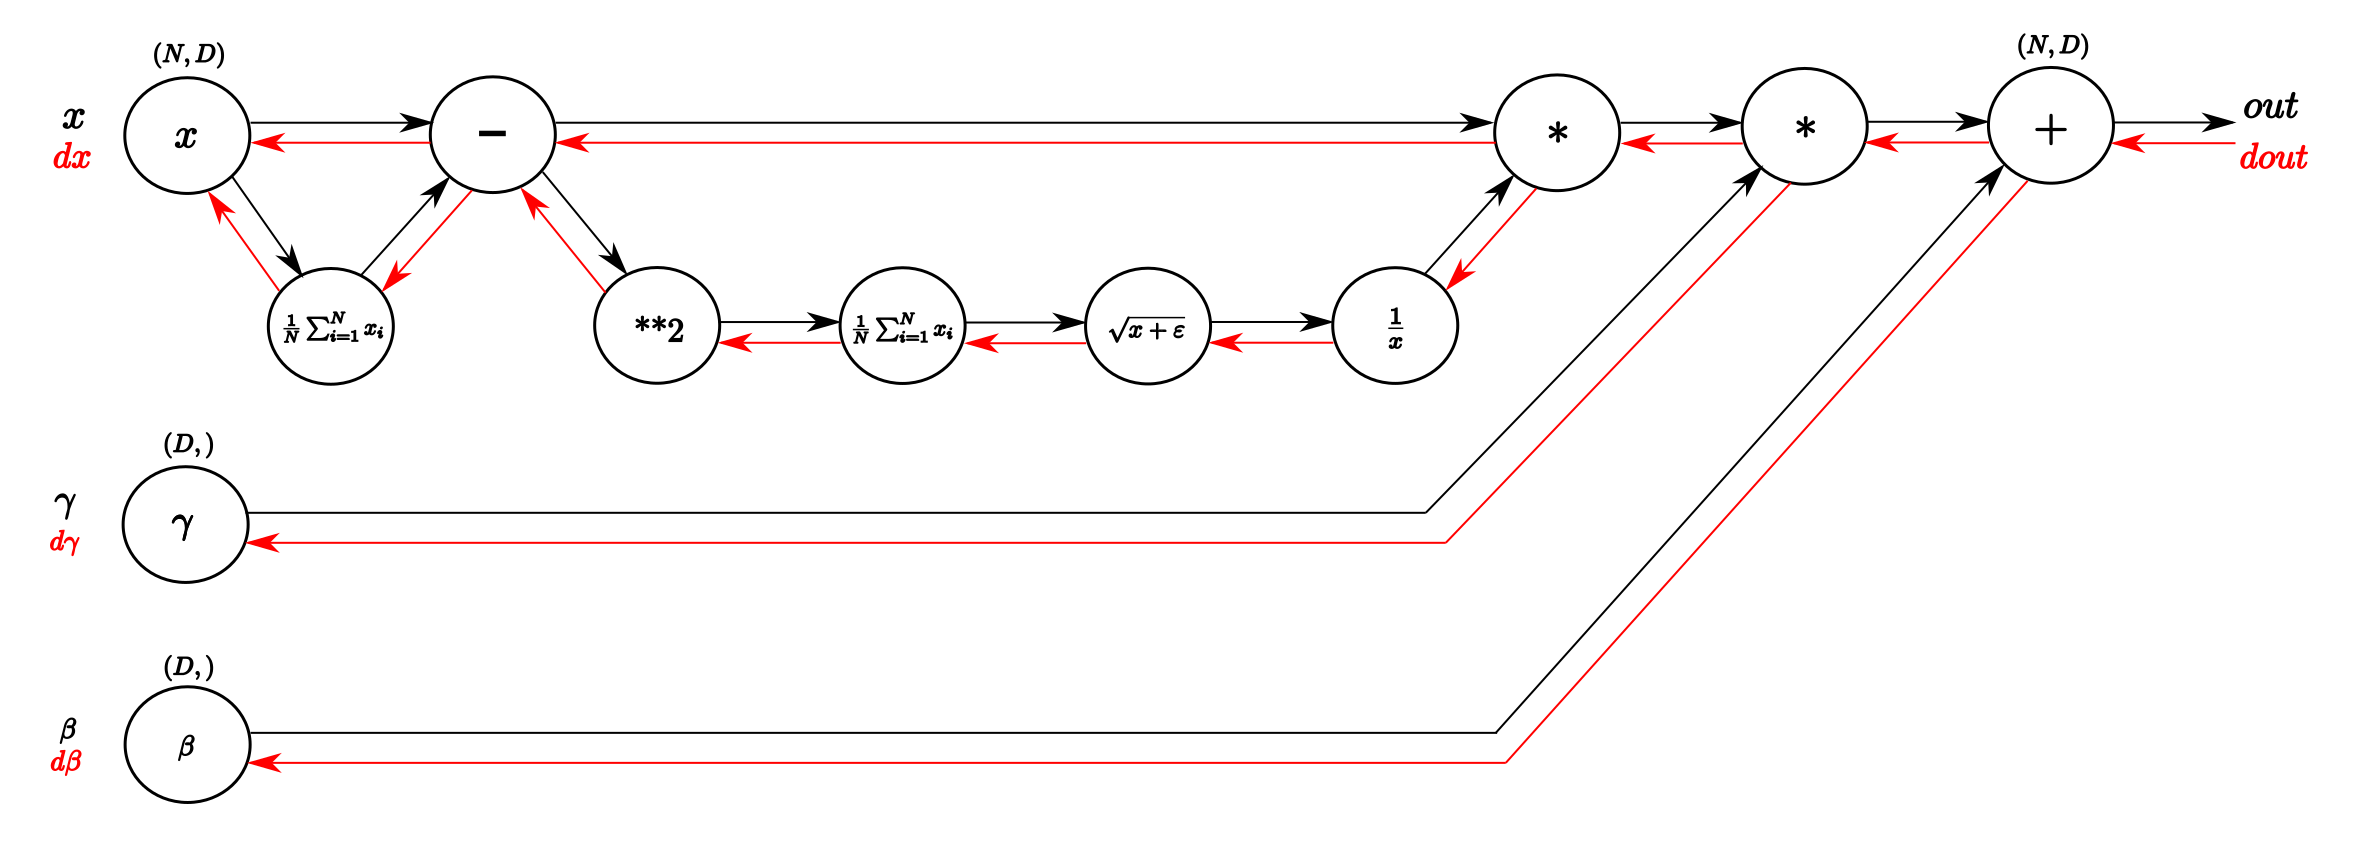

In [17]:
class BatchNormalization:
  """
  http://arxiv.org/abs/1502.03167
  """
  def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
      self.gamma = gamma
      self.beta = beta
      self.momentum = momentum
      self.input_shape = None # Conv 층=4차원, 완전 연결층=2차원

      # 테스트 시 사용하는 평균과 분산(즉, 업데이트 대상)
      self.running_mean = running_mean
      self.running_var = running_var

      # backward 시에 사용하는 중간 데이터
      self.batch_size = None
      self.xc = None
      self.std = None
      self.dgamma = None
      self.dbeta = None

  def forward(self, x, train_flg=True):
      self.input_shape = x.shape
      if x.ndim != 2:
          N, C, H, W = x.shape
          x = x.reshape(N, -1)

      out = self.__forward(x, train_flg)

      return out.reshape(*self.input_shape)


  def __forward(self, x, train_flg):
      if self.running_mean is None:
          N, D = x.shape
          self.running_mean = np.zeros(D)
          self.running_var = np.zeros(D)

      if train_flg:
          mu = x.mean(axis=0)
          xc = x - mu
          var = np.mean(xc**2, axis=0)
          std = np.sqrt(var + 10e-7)
          xn = xc / std

          self.batch_size = x.shape[0]
          self.xc = xc
          self.xn = xn
          self.std = std
          # 평균과 분산의 이동 평균 계산
          self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
          self.running_var = self.momentum * self.running_var + (1-self.momentum) * var
      else:
          # 추론 과정
          xc = x - self.running_mean # 추론과정이므로 이전에 계산된 평균의 이동 평균 사용
          xn = xc / ((np.sqrt(self.running_var + 10e-7))) # 마찬가지로 분산의 이동 평균값

      out = self.gamma * xn + self.beta
      return out


  def backward(self, dout):
      if dout.ndim != 2:
          N, C, H, W = dout.shape
          dout = dout.reshape(N, -1)

      dx = self.__backward(dout)

      dx = dx.reshape(*self.input_shape)
      return dx


  def __backward(self, dout):
      dbeta = dout.sum(axis=0)
      dgamma = np.sum(self.xn * dout, axis=0)
      dxn = self.gamma * dout
      dxc = dxn / self.std
      dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
      dvar = 0.5 * dstd / self.std
      dxc += (2.0 / self.batch_size) * self.xc * dvar
      dmu = np.sum(dxc, axis=0)
      dx = dxc - dmu / self.batch_size

      self.dgamma = dgamma
      self.dbeta = dbeta

      return dx

**Dropout**

In [19]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio # 랜덤하게 dropout 비율보다 크면 그대로 값을 내도록 만듦 (true = 1, false = 0임)
            return x * self.mask
        else:
            return x * (1 - self.dropout_ratio)  # 추론 시에는 dropout을 사용하지 않음. 단 기댓값을 스케일링하기 위해 (1 - dropout 비율) 만큼 값을 줄여줌.

    def backward(self, dout): #역전파 할 때도 mask 사용해야함
        return dout * self.mask

# Training

In [20]:
from torchvision import datasets, transforms

cifar10_train = datasets.MNIST(root='./data', train=True, download=True)
cifar10_test = datasets.MNIST(root='./data', train=False, download=True)

# flatten, normalization
x_train = cifar10_train.data.numpy().reshape(-1, 28 * 28).astype('float32') / 255.0
t_train = cifar10_train.targets
x_test = cifar10_test.data.numpy().reshape(-1, 28 * 28).astype('float32') / 255.0
t_test = cifar10_test.targets

# y one-hot encodeing
n = len(np.unique(t_train))
t_train = np.eye(n)[t_train]
t_test = np.eye(n)[t_test]

print(f'x_train.shape: {x_train.shape}')
print(f't_train.shape: {t_train.shape}')

100.0%
100.0%
100.0%
100.0%

x_train.shape: (60000, 784)
t_train.shape: (60000, 10)


정규화 기법을 하나씩 적용해보고, 그렇지 않은 경우의 결과를 비교해보세요!

epoch:0, train acc:0.07666666666666666, test acc:0.0875
epoch:1, train acc:0.12666666666666668, test acc:0.1043
epoch:2, train acc:0.16, test acc:0.1367
epoch:3, train acc:0.23333333333333334, test acc:0.192
epoch:4, train acc:0.32666666666666666, test acc:0.241
epoch:5, train acc:0.41333333333333333, test acc:0.2887
epoch:6, train acc:0.48, test acc:0.3246
epoch:7, train acc:0.5233333333333333, test acc:0.3479
epoch:8, train acc:0.51, test acc:0.3632
epoch:9, train acc:0.53, test acc:0.3765
epoch:10, train acc:0.5466666666666666, test acc:0.3971
epoch:11, train acc:0.58, test acc:0.4087
epoch:12, train acc:0.5833333333333334, test acc:0.4159
epoch:13, train acc:0.6166666666666667, test acc:0.429
epoch:14, train acc:0.6066666666666667, test acc:0.427
epoch:15, train acc:0.6166666666666667, test acc:0.4287
epoch:16, train acc:0.6233333333333333, test acc:0.4395
epoch:17, train acc:0.6166666666666667, test acc:0.4414
epoch:18, train acc:0.64, test acc:0.4571
epoch:19, train acc:0.6633333

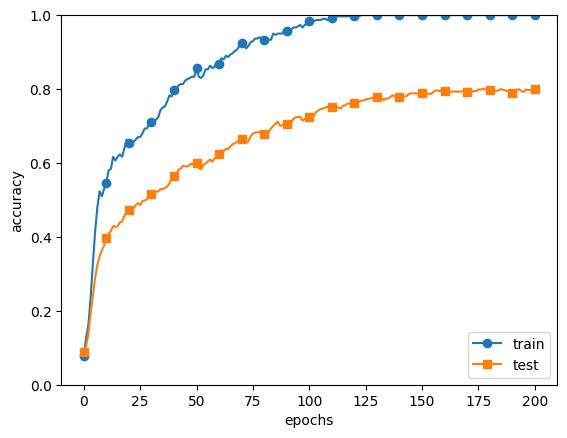

In [28]:
import matplotlib.pyplot as plt


x_train = x_train[:300]   # 적은 데이터를 가정
t_train = t_train[:300]

#network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
#                       weight_decay_lambda=0)
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                         weight_decay_lambda=0.1, use_dropout = True, dropout_ration = 0.2, use_batchnorm=True)


#optimizer = SGD(lr=0.03)
ptimizer = Adam(lr=0.01, beta1=0.9, beta2=0.999)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):   # 과적합 유도
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

1. SGD (lr: 0.01)
    
    epoch:200, train acc:1.0, test acc:0.6643

2. weight decay (lamda = 0.1), SGD (lr: 0.03 #0.01은 너무 언더피팅), Batch N
    
    epoch:200, train acc:1.0, test acc:0.6911

3. weight decay (lamda = 0.1), ADAM(lr=0.01, beta1=0.9, beta2=0.999), Batch N
    
    epoch:200, train acc:1.0, test acc:0.701

4. weight decay (lamda = 0.1), ADAM(lr=0.01, beta1=0.9, beta2=0.999), Batch N , Dropout (ratio:0.2)
   
   epoch:200, train acc:1.0, test acc:0.7996 

결론: 데이터가 작아서 (300개) 언더피팅이 심한 case (train accuracy가 금방 1이 됨)
   
    -> dropout으로 train을 다채롭게(?) 하는 것이 큰 도움이 되는 듯함